# 1. RNN的实现(不用框架)

In [1]:
%matplotlib inline
import math
import torch
from torch import nn
from torch.nn import functional as F
from d2l import torch as d2l

# num_steps即为T，表示看多长的序列
batch_size, num_steps = 32, 35
train_iter, vocab = d2l.load_data_time_machine(batch_size, num_steps)

In [2]:
# 独热编码
print(len(vocab))  # 28是因为按照char来分割的，包含26个字母+空格+unknown，共计28个
F.one_hot(torch.tensor([0,2]), len(vocab)) # [0,2] 表示物体下标，0表示第一个元素，2表示第3个元素
# 可以参考：https://blog.csdn.net/qq_43760191/article/details/121778553

28


tensor([[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0],
        [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0]])

In [12]:
# 小批量数据的形状是(批量大小，时间步数)
X = torch.arange(10).reshape((2,5)) # 批量大小为2，时间步数为5
print(X)
print(X.T)

# 为什么要对X做转置？是为了将时间步放到batch_size的前面；这样在后续遍历时，方便直接取出某一时刻下的一批数据
# 因为RNN是按照时间步来输入的模型？
print(F.one_hot(X.T, 28).shape)
print(F.one_hot(X.T, 28))

# 总结：
# inputs是访问一次train_iter得到的，维度为 “batch_size * num_steps”
# inputs.T的维度为 “num_steps * batch_size”
# inputs.T再经过one-hot编码后，维度为 “num_steps * batch_size * vocab_size”

tensor([[0, 1, 2, 3, 4],
        [5, 6, 7, 8, 9]])
tensor([[0, 5],
        [1, 6],
        [2, 7],
        [3, 8],
        [4, 9]])
torch.Size([5, 2, 28])
tensor([[[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
          0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
          0, 0, 0, 0, 0]],

        [[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
          0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
          0, 0, 0, 0, 0]],

        [[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
          0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
          0, 0, 0, 0, 0]],

        [[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
          0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
          0, 0, 0, 0, 0]]

In [14]:
# 初始化循环神经网络模型的模型参数
def get_params(vocab_size, num_hiddens, device):
    
    # 因为每个输入的词X经过one-hot处理之后，变成了一个长为vocab_size的向量，
    # 所以input和output的长度都是vocab_size！！！！！
    num_inputs = num_outputs = vocab_size
    
    # torch.randn返回一个均值为0，方差为1的正态分布（标准正态分布）中填充随机数的张量
    def normal(shape):
        return torch.randn(size=shape, device=device) * 0.01
    
    # 生成RNN对应所需的参数 & 初始化
    W_xh = normal((num_inputs, num_hiddens))
    W_hh = normal((num_hiddens, num_hiddens))
    b_h = torch.zeros(num_hiddens, device=device)
    W_hq = normal((num_hiddens, num_outputs))
    b_q = torch.zeros(num_outputs, device=device)
    
    # 所有参数，都需要设置梯度
    params = [W_xh, W_hh, b_h, W_hq, b_q]
    for param in params:
        param.requires_grad_(True)
    return params

In [15]:
# 一个init_rnn_state函数在初始化时返回隐藏状态
# 因为零时刻时没有上一刻的隐藏状态，所以要初始化隐藏状态
def init_rnn_state(batch_size, num_hiddens, device):
    # 注意，我们是放在一个tuple里，而不是一个tensor
    # 这是因为之后的LSTM会有两个不同的隐藏状态，所以为了统一，这里也放在tuple中了
    return (torch.zeros((batch_size, num_hiddens), device=device),)

In [16]:
# 下面的rnn函数定义了如何在一个时间步中计算隐藏状态和输出
# 调用一次，仅计算一个时间步？？？
# 感觉并不是，这取决于输入的inputs的形式；如果inputs的长度为时间步数，那么会遍历整个时间步；如果长度为1，那么确实仅走了一步
def rnn(inputs, state, params):
    W_xh, W_hh, b_h, W_hq, b_q = params  # 取出各个参数
    H, = state  # 从tuple中取出那个tensor H
    outputs = []
    
    # 我们前面做了转置，将时间步放在了前面；
    # 所以这里对inputs做遍历时，相当于就可以分别取出大小为batch_size的第0步的数据、第1步的数据、第2步的数据……
    # 也即每个X的大小为batch_size*num_inputs
    for X in inputs:
        # 输入X的大小为batch_size*num_inputs
        # 状态H的大小为batch_size*num_hiddens
        H = torch.tanh(torch.mm(X, W_xh) 
                       + torch.mm(H, W_hh) 
                       + b_h)
        # Y的大小则为batch_size*num_outputs
        Y = torch.mm(H, W_hq) + b_q
        # 把每个输出放进outputs之中
        outputs.append(Y)
    # 在dim=0上拼接，等于竖着拼接起来(行增加，列不变)；所以拼接后的结果为“(批量大小*时间步数) * num_outputs”
    # 相当于把三维的Y降维成两维了，其方法就是将前两维给并成一维了
    # 同时返回输出Y和中间状态H/state
    return torch.cat(outputs, dim=0), (H,)

In [17]:
# 创建一个类RNNModelScratch，来包装这些函数
class RNNModelScratch:
    # get_params, init_state, forward_fn均为函数
    def __init__(self, vocab_size, num_hiddens, device, 
                 get_params, init_state, forward_fn):
        self.vocab_size, self.num_hiddens = vocab_size, num_hiddens
        self.params = get_params(vocab_size, num_hiddens, device)
        self.init_state, self.forward_fn = init_state, forward_fn
        
    # 这里输入的X的大小和上文中“X = torch.arange(10).reshape((2,5))”所说的一样，是“批量大小 * 时间步数”这样的格式
    def __call__(self, X, state):
        # 转换后的X的大小为 “时间步数 * 批量大小 * vocab_size”
        X = F.one_hot(X.T, self.vocab_size).type(torch.float32)
        # 下面的forward_fn，也即调用上方的rnn函数，得到“输出 & 更新后的状态”
        # 其中输出的Y的大小为“(批量大小*时间步数) * num_outputs”（前两维并成一维了）
        return self.forward_fn(X, state, self.params)
    
    # 初始化第0个时间点的隐藏状态
    def begin_state(self, batch_size, device):
        return self.init_state(batch_size, self.num_hiddens, device)

In [34]:
# 检查输出是否具有正确的形状
num_hiddens = 512
net = RNNModelScratch(len(vocab), num_hiddens, d2l.try_gpu(), 
                      get_params, init_rnn_state, rnn)

# 将时刻0的那些隐藏状态初始化
state = net.begin_state(X.shape[0], d2l.try_gpu())

# X中包含5个时间步，所以会走完这5步
Y, new_state = net(X.to(d2l.try_gpu()), state)

print(Y.shape)  # 输出的Y的大小为“(批量大小*时间步数) * num_outputs”，也即(5*2)*28
print(len(new_state))  # tuple的长度为1
print(new_state[0].shape)  # 每个状态的维度为 batch_size * num_hiddens，也即2*512

torch.Size([10, 28])
1
torch.Size([2, 512])


In [37]:
# 首先定义预测函数，来生成用户提供的prefix之后的新字符
# num_preds表示需要在prefix后面再生成几个词
def predict_ch8(prefix, num_preds, net, vocab, device):
    """预测任务：在给定的 'prefix' 后面生成新字符。"""
    
    state = net.begin_state(batch_size=1, device=device)
    outputs = [ vocab[prefix[0]] ]  # 获取prefix中的第一个词在vocab中对应的下标，并将其放到outputs中
    
    # 获取outputs中的最后一个词，也即最近预测的这一个词，（之后会作为下一个时刻的输入）
    get_input = lambda: torch.tensor([outputs[-1]],device=device).reshape(1,1)
    
    # 遍历prefix的除第一个词外的剩余部分：
    for y in prefix[1:]:
        # 不需要输出，只需要state（因为此时prefix已经存在了，所以不需要预测，只需要用已有的prefix来更新我的state）
        # 由于这里的get_input()给出的是1*1的张量，所以只会向前计算一步
        _, state = net(get_input(), state)
        outputs.append(vocab[y])
    
    # 真正开始预测：
    for _ in range(num_preds):
        y, state = net(get_input(), state)
        # 获得y中最大的那个值的下标，即为预测结果（因为y是one-hot的向量）
        outputs.append(int(y.argmax(dim=1).reshape(1)))
    
    # 最后，将下标转成字符串并输出
    return ''.join([vocab.idx_to_token[i] for i in outputs])

predict_ch8('time traveller ', 10, net, vocab, d2l.try_gpu())  # 还没训练，这是随机初始化后的预测 

'time traveller rwsxcsxcsx'

① 梯度裁剪$$\mathbf{g} \leftarrow \min\left(1, \frac{\theta}{\|\mathbf{g}\|}\right) \mathbf{g}$$

In [38]:
def grad_clipping(net, theta):
    """裁剪梯度。"""
    # 注意，我们这里是将所有层能够参与训练的参数全部都给取出来了
    if isinstance(net, nn.Module):
        params = [p for p in net.parameters() if p.requires_grad]
    else:
        params = net.params
    
    # 计算norm范数，也是把所有层的所有参数的梯度全部合起来算norm
    norm = torch.sqrt(sum(torch.sum((p.grad**2)) for p in params))
    if norm > theta:
        for param in params:
            param.grad[:] *= theta / norm

In [39]:
# 定义一个函数来训练只有一个迭代周期epoch的模型
def train_epoch_ch8(net, train_iter, loss, updater, device, use_random_iter):
    """训练模型一个迭代周期"""
    state, timer = None, d2l.Timer()
    metric = d2l.Accumulator(2)
    for X, Y in train_iter:
        # 因为如果使用use_random_iter的话，说明各个batch之间的数据之间互相是不连续的
        # 这样的话上一轮数据的state不应该用到这一轮中来，所以此时我们每轮都需要将初始状态都重新初始化为0
        if state is None or use_random_iter:
            state = net.begin_state(batch_size=X.shape[0],device=device)
        else:
            if isinstance(net, nn.Module) and not isinstance(state, tuple):
                # 参考链接：https://blog.csdn.net/qq_27825451/article/details/95498211
                # detach_会将一个tensor从创建它的图中分离，并把它设置成叶子tensor
                # 这样的话state的值会保持不变，但是把前面的梯度都给抛弃掉了，这样做backward的时候只考虑现在和之后的事了
                state.detach_()
            else:
                for s in state:
                    s.detach_()
        
        # Y也做了转置，也是为了将时间步放到batch_size的前面；reshape则是将前两维的“(批量大小*时间步数)”并成一维
        y = Y.T.reshape(-1)
        X, y = X.to(device), y.to(device)
        
        # forward训练 & 计算loss
        y_hat, state = net(X, state)
        # y_hat和y都是为“(批量大小*时间步数) * num_outputs”的格式了（将前两维并成一维）
        l = loss(y_hat, y.long()).mean()  # 在loss看来，这就是一个多分类问题
        
        if isinstance(updater, torch.optim.Optimizer):
            updater.zero_grad()
            l.backward()
            grad_clipping(net,1)  # 对参数做一次clipping
            updater.step()
        else:
            l.backward()
            grad_clipping(net,1)
            updater(batch_size=1)
        
        metric.add(l * y.numel(), y.numel())  # numel函数用于获取tensor中一共包含多少个元素
    
    # 计算平均的误差，再做个指数/计算perplexity；另一个返回值为计算的速度
    return math.exp(metric[0] / metric[1]), (metric[1] / timer.stop())

In [40]:
# 训练函数支持“从零开始或使用高级API实现”的循环神经网络模型
def train_ch8(net, train_iter, vocab, lr, num_epochs, device, use_random_iter=False):
    """训练模型"""
    loss = nn.CrossEntropyLoss()
    animator = d2l.Animator(xlabel='epoch', ylabel='perplexity', legend=['train'],xlim=[10,num_epochs])
    
    if isinstance(net, nn.Module):
        updater = torch.optim.SGD(net.parameters(), lr)
    else:
        updater = lambda batch_size: d2l.sgd(net.params, lr, batch_size)
    
    # 将predict_ch8封装一下，往后预测 50 个字符
    predict = lambda prefix: predict_ch8(prefix, 50, net, vocab, device)
    
    for epoch in range(num_epochs):
        # 调用刚定义的train_epoch_ch8函数，并获得返回值perplexity和计算的速度
        ppl, speed = train_epoch_ch8(net, train_iter, loss, updater, device, use_random_iter)
        # 每预测10个epoch，看一下预测的结果
        if (epoch + 1) % 10 == 0:
            print(predict('time traveller'))
            animator.add(epoch + 1, [ppl])
    
    print(f'困惑度 {ppl:.1f}, {speed:.1f} 标记/秒 {str(device)}')
    print(predict('time traveller'))
    print(predict('traveller'))

困惑度 1.0, 74602.0 标记/秒 cuda:0
time traveller for so it will be convenient to speak of himwas e
travelleryou can show black is white by argument said filby


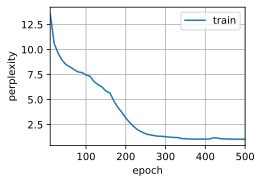

In [41]:
# 现在我们可以训练循环神经网络模型
num_epochs, lr = 500, 1
train_ch8(net, train_iter, vocab, lr, num_epochs, d2l.try_gpu())

困惑度 1.4, 75607.9 标记/秒 cuda:0
time travellerit s against reason said filby but you willnever c
travellerit s against reason said filby but you willnever c


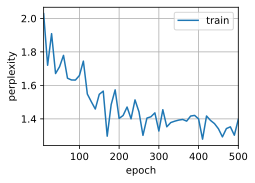

In [42]:
# 最后，让我们检查一下使用随机抽样方法的结果
train_ch8(net, train_iter, vocab, lr, num_epochs, d2l.try_gpu(), use_random_iter=True) 

# 2. RNN的实现(用框架)

In [4]:
import torch
from torch import nn
from torch.nn import functional as F
from d2l import torch as d2l

batch_size, num_steps = 32, 35
train_iter, vocab = d2l.load_data_time_machine(batch_size, num_steps)

In [5]:
# 定义模型
num_hiddens = 256
rnn_layer = nn.RNN(len(vocab), num_hiddens)

In [6]:
# 需要我们手动，使用张量来初始化隐藏状态
state = torch.zeros((1, batch_size, num_hiddens))
state.shape

torch.Size([1, 32, 256])

In [9]:
# 通过一个隐藏状态和一个输入，我们可以用更新后的隐藏状态计算输出
# 随机初始化输入，其维度为 “时间步数 * 批量大小 * vocab_size”
X = torch.rand(size=(num_steps, batch_size, len(vocab)))
# 根据输入X和初始状态state来跑RNN
Y, state_new = rnn_layer(X, state)

# 注意这里Y并不是输出，而是每个时间步的隐藏状态；共有35步，且每步的隐藏状态的维度为“batch_size * num_hiddens”
# 所以其最后一维为256/num_hiddens，而不是28/len(vocab)
# 也即rnn_layer只包含隐藏的循环层，我们还需要另外创建一个单独的输出层
print(Y.shape)  # 输出为 “时间步数 * 批量大小 * num_hiddens”

# ps：所以state应该是Y中的最后一项
print(state_new.shape)  # 输出为“batch_size * num_hiddens”

torch.Size([35, 32, 256])
torch.Size([1, 32, 256])


In [10]:
# 我们为一个完整的循环神经网络模型定义一个RNNModel类
class RNNModel(nn.Module):
    """循环神经网络模型"""
    def __init__(self, rnn_layer, vocab_size, **kwargs):
        super(RNNModel, self).__init__(**kwargs)
        
        # 注：pytorch的rnn只包括隐藏层，不包括输出层的！
        self.rnn = rnn_layer
        self.vocab_size = vocab_size
        self.num_hiddens = self.rnn.hidden_size
        
        # 构造我们的linear的输出层
        if not self.rnn.bidirectional:
            self.num_directions = 1
            self.linear = nn.Linear(self.num_hiddens, self.vocab_size)
        else:
            self.num_directions = 2
            self.linear = nn.Linear(self.num_hiddens * 2, self.vocab_size)  
            
    def forward(self, inputs, state):
        # 对inputs做one-hot编码
        X = F.one_hot(inputs.T.long(), self.vocab_size)
        X = X.to(torch.float32)
        
        Y, state = self.rnn(X, state)
        # 将前两维的num_steps和batch_size并成一维，然后送入linear层中去
        output = self.linear(Y.reshape((-1, Y.shape[-1])))
        
        return output, state

    def begin_state(self, device, batch_size=1):
        if not isinstance(self.rnn, nn.LSTM):
            # 其他RNN类模型只需要一个状态
            return torch.zeros((self.num_directions * self.rnn.num_layers,
                                batch_size, self.num_hiddens),
                               device=device)
        else:
            # LSTM会有两个状态需要初始化
            return (torch.zeros((self.num_directions * self.rnn.num_layers,
                                 batch_size, self.num_hiddens),
                                device=device), 
                    torch.zeros((self.num_directions * self.rnn.num_layers,
                                 batch_size, self.num_hiddens), 
                                device=device))

In [12]:
# 用一个具有随机权重的模型进行预测
device = d2l.try_gpu()

net = RNNModel(rnn_layer, vocab_size=len(vocab))
net = net.to(device)

d2l.predict_ch8('time traveller', 10, net, vocab, device)

'time travelleruuruuruuru'

perplexity 1.3, 295424.6 tokens/sec on cuda:0
time traveller hal tha hing wi n stimuthing wi not sa dotryou su
traveller him thane almove a motight onatheretithto bu nof 


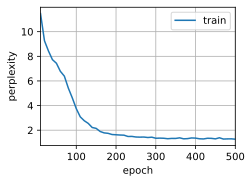

In [13]:
# 使用高级API训练模型
num_epochs, lr = 500, 1
d2l.train_ch8(net, train_iter, vocab, lr, num_epochs, device)